# Mini Challenge: Deep Learning for Images and Signals
- Name: Nils Fahrni
- Submission Date: t.b.d.

## How does the performance of a U-Net semantic segmentation model differ between scenes of city streets and non-city streets in the BDD100K dataset?

## Package Usage

In [1]:
#%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "dlbs"

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import wandb
import random

env: "WANDB_NOTEBOOK_NAME"="dlbs"


In [2]:
RANDOM_SEED = 1337

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Dataset
Berkeley Deep Drive Dataset: https://arxiv.org/abs/1805.04687

In [3]:
import os

BASE_DATA_PATH = os.path.join('data', 'bdd100k', 'images', '10k', 'train')
BASE_LABELS_PATH = os.path.join('data', 'bdd100k', 'labels', 'sem_seg', 'masks', 'train')

### Exploration

[Become one with the data](https://karpathy.github.io/2019/04/25/recipe/#:~:text=1.%20Become%20one%20with%20the%20data)

#### Metrics

#### Looking at some samples

#### Spatial Heatmap

https://doc.bdd100k.com/format.html#semantic-segmentation

In [4]:
class_dict = {
    0: "road",
    1: "sidewalk",
    2: "building",
    3: "wall",
    4: "fence",
    5: "pole",
    6: "traffic light",
    7: "traffic sign",
    8: "vegetation",
    9: "terrain",
    10: "sky",
    11: "person",
    12: "rider",
    13: "car",
    14: "truck",
    15: "bus",
    16: "train",
    17: "motorcycle",
    18: "bicycle"
}

Processing Classes:   0%|          | 0/19 [00:00<?, ?it/s]

Processing Classes: 100%|██████████| 19/19 [01:25<00:00,  4.48s/it]


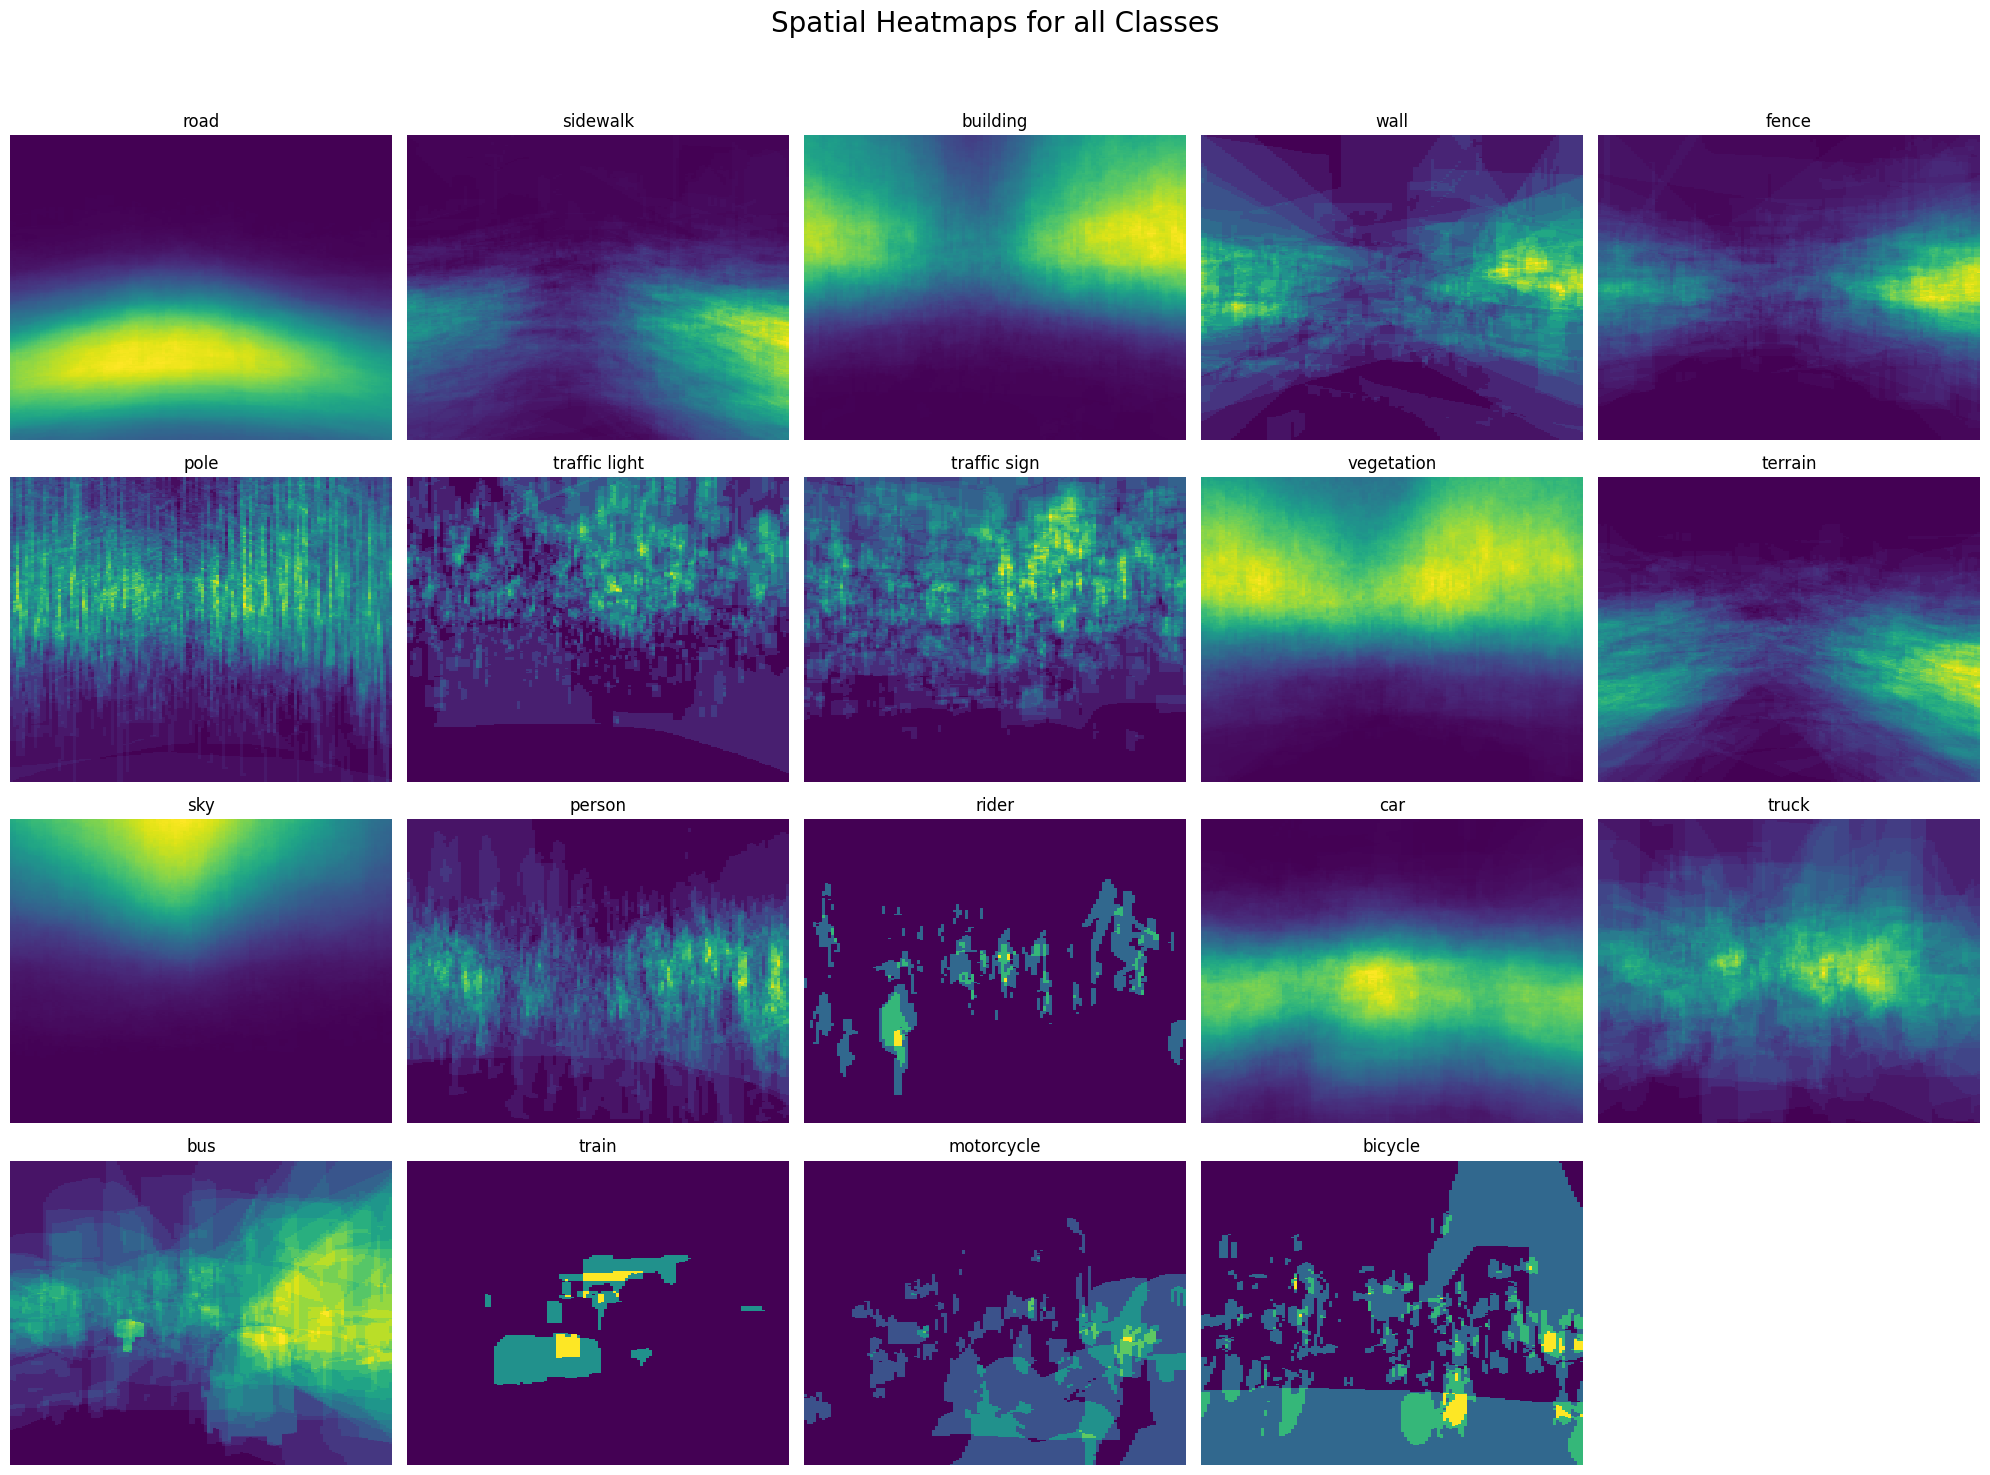

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm import tqdm

label_folder = BASE_LABELS_PATH

target_width, target_height = 128, 228
N_SAMPLES = 1000

heatmaps = {class_id: np.zeros((target_height, target_width), dtype=np.float32) for class_id in class_dict.keys()}

for class_id, class_name in tqdm(class_dict.items(), desc="Processing Classes"):
    all_files = [f for f in os.listdir(label_folder) if f.endswith('.png')]
    sampled_files = random.sample(all_files, min(N_SAMPLES, len(all_files)))
    
    for file in tqdm(sampled_files, desc=f"Sampling {class_name}", leave=False):
        label_path = os.path.join(label_folder, file)
        with Image.open(label_path) as img:
            label = np.array(img)
            
            label_resized = np.array(Image.fromarray(label).resize((target_width, target_height), Image.NEAREST))

            mask = (label_resized == class_id)
            heatmaps[class_id] += mask.astype(np.float32)

    heatmaps[class_id] /= len(sampled_files)

fig, axs = plt.subplots(4, 5, figsize=(20, 15))
fig.suptitle("Spatial Heatmaps for all Classes", fontsize=20)

for class_id, class_name in class_dict.items():
    ax = axs[class_id // 5, class_id % 5]
    sns.heatmap(heatmaps[class_id], ax=ax, cmap="viridis", cbar=False)
    ax.set_title(class_name)
    ax.axis('off')

for i in range(len(class_dict), 4 * 5):
    fig.delaxes(axs[i // 5, i % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Observations**
- Train, Rider, Motorcycle and bicycle seem to be rather underrepresented since these objects' shapes are still clearly visible and don't have a high overlap

#### Co-Occurence

Processing Masks in data\bdd100k\labels\sem_seg\masks\train: 100%|██████████| 7000/7000 [02:13<00:00, 52.41it/s]


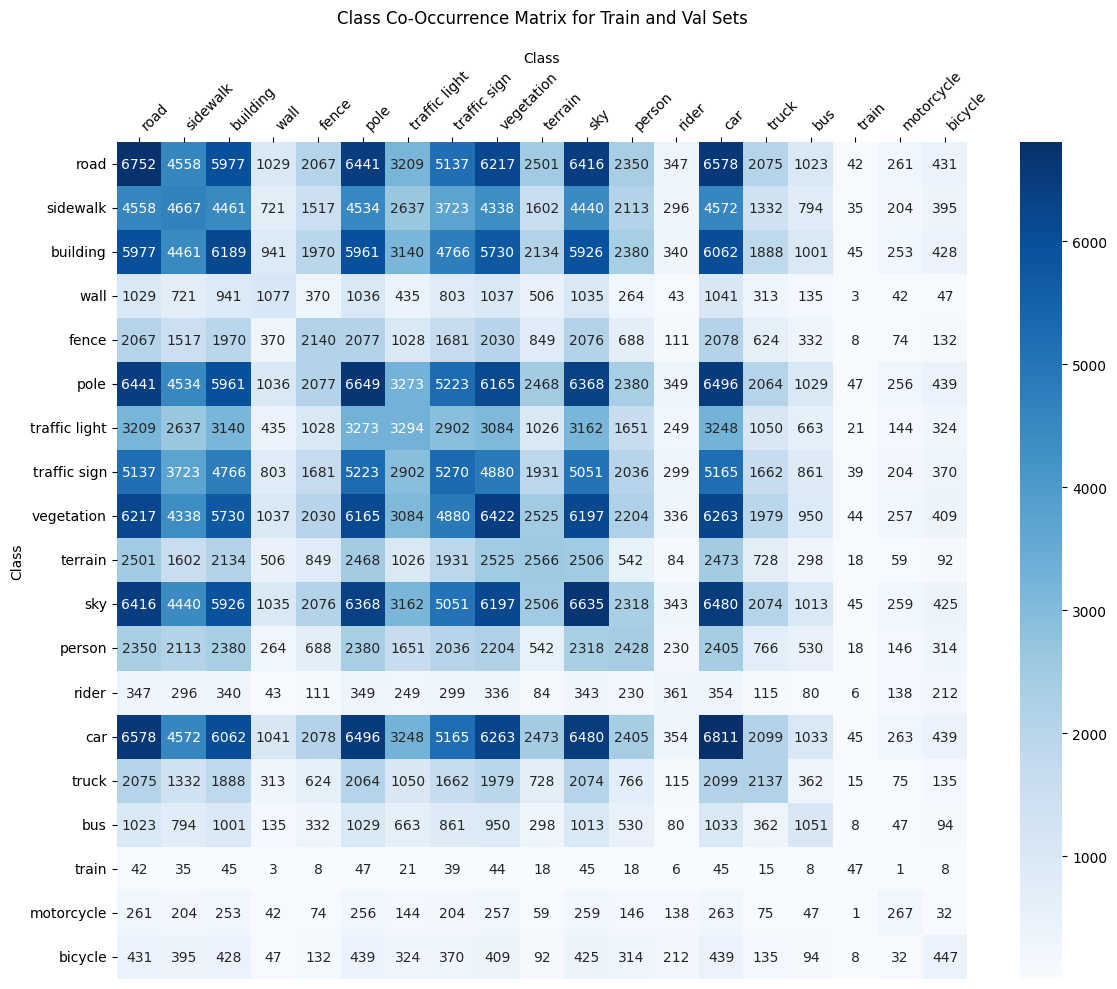

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

label_folders = [BASE_LABELS_PATH]
num_classes = len(class_dict)
class_names = list(class_dict.values())

co_occurrence_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

for label_folder in label_folders:
    all_files = [f for f in os.listdir(label_folder) if f.endswith('.png')]
    
    for file in tqdm(all_files, desc=f"Processing Masks in {label_folder}"):
        label_path = os.path.join(label_folder, file)
        with Image.open(label_path) as img:
            label = np.array(img)

            unique_classes = np.unique(label)

            for i in range(len(unique_classes)):
                for j in range(i, len(unique_classes)):
                    class_i = unique_classes[i]
                    class_j = unique_classes[j]
                    if class_i < num_classes and class_j < num_classes:
                        co_occurrence_matrix[class_i, class_j] += 1
                        if class_i != class_j:
                            co_occurrence_matrix[class_j, class_i] += 1

plt.figure(figsize=(12, 10))
ax = sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Class Co-Occurrence Matrix for Train and Val Sets", pad=20)
plt.xlabel("Class")
plt.ylabel("Class")

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

plt.xticks(rotation=45, ha="left")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Training and Evaluation Skeleton

[Set up the end-to-end training/evaluation skeleton + get dumb baselines](https://karpathy.github.io/2019/04/25/recipe/#:~:text=Set%20up%20the%20end%2Dto%2Dend%20training/evaluation%20skeleton%20%2B%20get%20dumb%20baselines)

In [5]:
import torch
import torch.nn as nn
from torcheval.metrics import MulticlassAccuracy

RANDOM_SEED = 1337

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


#### Data Loading & Splitting

In [6]:
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import torch

from data import BDD100KDataset, custom_split_dataset_with_det, check_dataset_overlap

DET_TRAIN_PATH = './data/bdd100k/labels/det_20/det_train.json'
DET_VAL_PATH = './data/bdd100k/labels/det_20/det_val.json'

split_data = custom_split_dataset_with_det(base_data_path=BASE_DATA_PATH, 
                                           base_labels_path=BASE_LABELS_PATH, 
                                           det_train_path=DET_TRAIN_PATH, 
                                           det_val_path=DET_VAL_PATH)

check_dataset_overlap(
    split_data['train']['image_filenames'],
    split_data['val']['image_filenames'],
    split_data['test']['image_filenames']
)

image_transform = transforms.Compose([
    transforms.Resize((72, 128)),
    transforms.ToTensor(),
])

label_transform = transforms.Compose([
    transforms.Resize((72, 128), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long)),
])

train_dataset = BDD100KDataset(
    images_dir=split_data['train']['data_folder'],
    labels_dir=split_data['train']['labels_folder'],
    filenames=split_data['train']['image_filenames'],
    transform=image_transform,
    target_transform=label_transform,
    scene_info=split_data['train']['scene_map']
)

val_dataset = BDD100KDataset(
    images_dir=split_data['val']['data_folder'],
    labels_dir=split_data['val']['labels_folder'],
    filenames=split_data['val']['image_filenames'],
    transform=image_transform,
    target_transform=label_transform,
    scene_info=split_data['val']['scene_map']
)

test_dataset = BDD100KDataset(
    images_dir=split_data['test']['data_folder'],
    labels_dir=split_data['test']['labels_folder'],
    filenames=split_data['test']['image_filenames'],
    transform=image_transform,
    target_transform=label_transform,
    scene_info=split_data['test']['scene_map']
)



--- Split Sizes ---
- Train Images: 2518
- Val Images: 454
- Test Images: 454

--- Overlap Report ---
✔️ No overlap detected between train and validation sets.
✔️ No overlap detected between train and test sets.
✔️ No overlap detected between validation and test sets.



In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Size of train dataset: {len(train_dataset)} samples")
print(f"Size of validation dataset: {len(val_dataset)} samples")
print(f"Size of test dataset: {len(test_dataset)} samples")

Size of train dataset: 2518 samples
Size of validation dataset: 454 samples
Size of test dataset: 454 samples


Analyzing Class Distribution: 100%|██████████| 454/454 [00:06<00:00, 72.43it/s]


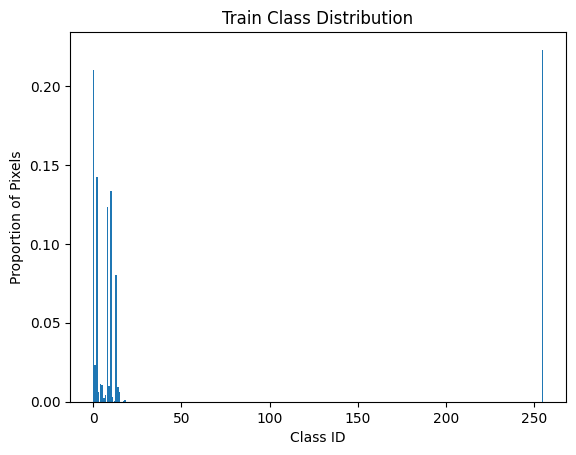

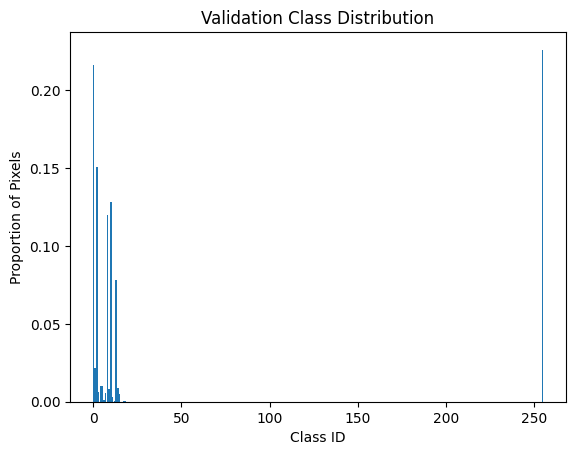

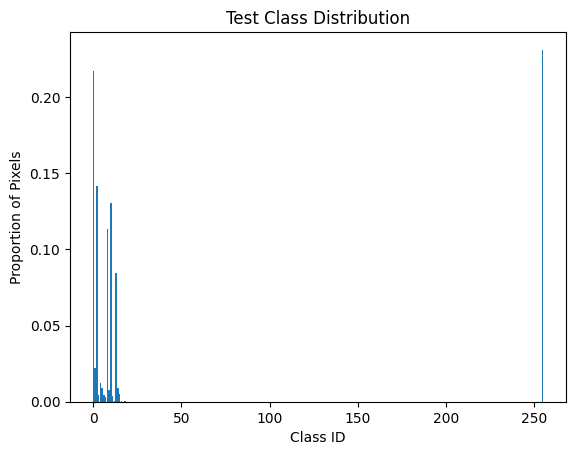

In [8]:
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

def analyze_class_distribution(dataset, num_classes):
    from tqdm import trange

    class_counts = Counter()

    # Use a range-based loop to avoid out-of-range errors
    for idx in trange(len(dataset), desc="Analyzing Class Distribution"):
        try:
            _, mask, _ = dataset[idx]  # Access dataset item
            mask_array = np.array(mask)  # Convert mask to numpy array
            unique, counts = np.unique(mask_array, return_counts=True)
            class_counts.update(dict(zip(unique, counts)))
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            continue

    # Normalize counts
    total_pixels = sum(class_counts.values())
    class_distribution = {cls: count / total_pixels for cls, count in class_counts.items()}

    return class_counts, class_distribution


# Analyze train, val, and test splits
train_class_counts, train_class_distribution = analyze_class_distribution(train_dataset, num_classes=19)
val_class_counts, val_class_distribution = analyze_class_distribution(val_dataset, num_classes=19)
test_class_counts, test_class_distribution = analyze_class_distribution(test_dataset, num_classes=19)

# Visualize the distribution
def plot_class_distribution(class_distribution, title):
    classes = list(class_distribution.keys())
    proportions = list(class_distribution.values())

    plt.bar(classes, proportions)
    plt.xlabel('Class ID')
    plt.ylabel('Proportion of Pixels')
    plt.title(title)
    plt.show()

# Plot for each split
plot_class_distribution(train_class_distribution, "Train Class Distribution")
plot_class_distribution(val_class_distribution, "Validation Class Distribution")
plot_class_distribution(test_class_distribution, "Test Class Distribution")


#### Training and Evaluation Skeleton

In [9]:
import os
import torch
import wandb
from torchmetrics import JaccardIndex

class Trainer:
    def __init__(self, model, criterion, optimizer, lr, epochs, weight_init, seed, device, verbose, run_name):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.weight_init = weight_init
        self.seed = seed
        self.device = device
        self.verbose = verbose
        self.run_name = run_name

        self.model.to(self.device)

        self.iou_metric = JaccardIndex(num_classes=19, task="multiclass").to(self.device)

        self._set_seed(self.seed)
        wandb.init(project="dlbs", name=self.run_name)
        
        self.run_id = wandb.run.id
        self.best_val_loss = float('inf')

        os.makedirs("models", exist_ok=True)

    def _set_seed(self, seed):
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)

    def _initialize_weights(self):
        if self.weight_init:
            self.model.apply(self.weight_init)
        else:
            for m in self.model.modules():
                if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def _save_model(self, val_loss):
        """
        Save the model if the current validation loss is lower than the best validation loss.
        """
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            model_name = f"{self.model.__class__.__name__}_{self.run_id}.pth"
            save_path = os.path.join("models", model_name)
            
            torch.save(self.model.state_dict(), save_path)
            
            wandb.save(model_name)

            if self.verbose:
                print(f"Model saved to {save_path} with val_loss {val_loss:.4f}")

    def _train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        self.iou_metric.reset()

        for images, labels, _ in train_loader:
            images, labels = images.to(self.device), labels.to(self.device, dtype=torch.long)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

            # Calculate IoU, ignoring 255-labeled pixels
            _, predicted = outputs.max(1)
            mask = labels != 255  # Create a mask for valid pixels
            self.iou_metric.update(predicted[mask], labels[mask])

            # Clear cache to manage GPU memory
            del images, labels, outputs
            torch.cuda.empty_cache()

        epoch_loss = running_loss / len(train_loader)
        epoch_iou = self.iou_metric.compute().item()

        return epoch_loss, epoch_iou

    def _validate_epoch(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        self.iou_metric.reset()

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(self.device), labels.to(self.device, dtype=torch.long)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()

                # Calculate IoU, ignoring 255-labeled pixels
                _, predicted = outputs.max(1)
                mask = labels != 255  # Create a mask for valid pixels
                self.iou_metric.update(predicted[mask], labels[mask])

                # Clear cache to manage GPU memory
                del images, labels, outputs
                torch.cuda.empty_cache()

        epoch_loss = running_loss / len(val_loader)
        epoch_iou = self.iou_metric.compute().item()

        return epoch_loss, epoch_iou

    def run(self, train_loader, val_loader):
        self._initialize_weights()

        for epoch in range(self.epochs):
            train_loss, train_iou = self._train_epoch(train_loader)
            val_loss, val_iou = self._validate_epoch(val_loader)

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.epochs} - "
                      f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f} - "
                      f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

            wandb.log({
                "epoch": epoch+1,
                "train_loss": train_loss,
                "train_iou": train_iou,
                "val_loss": val_loss,
                "val_iou": val_iou
            })

            # Save the model if it's the best one so far
            self._save_model(val_loss)

    def test(self, test_loader):
        test_loss, test_iou = self._validate_epoch(test_loader)

        print(f"Test Loss: {test_loss:.4f} - Test IoU: {test_iou:.4f}")
        wandb.log({
            "test_loss": test_loss,
            "test_iou": test_iou
        })

### Baseline: (Tiny-)U-Net

In [10]:
import collections

ordered_class_dists = collections.OrderedDict(sorted(train_class_distribution.items()))

class_weights = torch.tensor(list(ordered_class_dists.values()), device=device).float()

len(class_weights)

20

In [11]:
overfit_datalader = DataLoader(train_dataset[:8], batch_size=8, shuffle=True)

In [12]:
import torch.optim as optim
from core import UNetBaseline

model = UNetBaseline(num_classes=20).to(device)
criterion = nn.CrossEntropyLoss()#ignore_index=255, weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Trainer(model, 
        criterion, 
        optimizer, 
        lr=1e-4, 
        epochs=1000, 
        weight_init=None, 
        seed=RANDOM_SEED, 
        device=device, 
        verbose=True, 
        run_name="unet_baseline").run(overfit_datalader, 
                                      overfit_datalader)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: okaynils. Use `wandb login --relogin` to force relogin


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Overfit

[Overfit](https://karpathy.github.io/2019/04/25/recipe/#:~:text=3.-,Overfit,-At%20this%20stage)

### Regularization

[Regularize](https://karpathy.github.io/2019/04/25/recipe/#:~:text=4.-,Regularize,-Ideally%2C%20we%20are)

### Tuning the model

[Tune](https://karpathy.github.io/2019/04/25/recipe/#:~:text=5.-,Tune,-You%20should%20now)

### Ensembles & Leave it training

[Squeeze out the juice](https://karpathy.github.io/2019/04/25/recipe/#:~:text=Squeeze%20out%20the%20juice)